>儒冠多误身

* 考虑同时在mysql上实现一样的功能
* 选取合适的读取方式，比如让 日期列，读取为日期格式
    * parse_dates={'col_new':[0]}


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# 1. 读取用户购买记录文本

In [3]:
orders = pd.read_table('python_for_data_science-master/Data/purchase_order.tab',names=['time','action','user_Id','product','quantity','price'],
                     parse_dates={'date':[0]})

In [4]:
orders.head()

,date,action,user_Id,product,quantity,price
0,2015-07-01 00:00:01,order,U312622727,P0006944501,1,1069.0
1,2015-07-01 00:00:03,order,U239012343,P0006018073,1,1680.0
2,2015-07-01 00:00:19,order,U10007697373,P0002267974,1,285.0
3,2015-07-01 00:01:10,order,U296328517,P0016144236,1,550.0
4,2015-07-01 00:01:36,order,U300884570,P0014516980122,1,249.0


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54772 entries, 0 to 54771
Data columns (total 6 columns):
date        54772 non-null datetime64[ns]
action      54772 non-null object
user_Id     54772 non-null object
product     54772 non-null object
quantity    54772 non-null int64
price       54721 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.9+ MB


# 条件查询

In [6]:
orders.loc[orders['product']=='P0006944501','price'].describe()

count       8.0
mean     1069.0
std         0.0
min      1069.0
25%      1069.0
50%      1069.0
75%      1069.0
max      1069.0
Name: price, dtype: float64

* 统计产品类数

In [7]:
len(orders['product'].unique())

20054

* 统计各类产品售价

In [8]:
orders.groupby('product')['price'].mean().head()

product
P0000005913       1590.0
P0000006020       1290.0
P0000006591        999.0
P0000007744       3280.0
P0000008190011    5083.0
Name: price, dtype: float64

MySQL实现

```select product,avg(price) from orders
groupby by product
limit 5
```

* 按产品种类的售价进行排序

In [9]:
orders.groupby('product')['price'].mean().sort_values(ascending=False).head()

product
P0000143511    438888.0
P0000143500    438888.0
P0006584093    320000.0
P0025280275    183900.0
P0000150006    111375.0
Name: price, dtype: float64

MySQL实现

```select product,avg(price) from orders
group by product
order by avg(price) desc
limit 5
```

* 求得用户每次消费金额

In [10]:
orders['total_price'] = orders['price']*orders['quantity']

In [11]:
orders.head()

,date,action,user_Id,product,quantity,price,total_price
0,2015-07-01 00:00:01,order,U312622727,P0006944501,1,1069.0,1069.0
1,2015-07-01 00:00:03,order,U239012343,P0006018073,1,1680.0,1680.0
2,2015-07-01 00:00:19,order,U10007697373,P0002267974,1,285.0,285.0
3,2015-07-01 00:01:10,order,U296328517,P0016144236,1,550.0,550.0
4,2015-07-01 00:01:36,order,U300884570,P0014516980122,1,249.0,249.0


* 按用户消费总金额排名

In [12]:
orders.groupby('user_Id')['total_price'].sum().sort_values(ascending=False).head()

user_Id
U166708333      2942744.0
U10120098943    1451117.0
U142809250       747550.0
U1006283751      515688.0
U10114715330     456782.0
Name: total_price, dtype: float64

MySQL实现
```
select from orders
group by user_Id
order by sum(total_price) desc
limit 5
```

# 2. 读取用户浏览记录
* .tab文件

In [13]:
views = pd.read_table('python_for_data_science-master/Data/purchase_view.tab',encoding='utf8',names=['time','action','user_Id','product'], parse_dates={'date':[0]})

In [14]:
views.head()

,date,action,user_Id,product
0,2015-07-01 00:00:01,view,U129297265,P0023468384
1,2015-07-01 00:00:03,view,U321001337,P0018926456
2,2015-07-01 00:00:05,view,U10070718237,P0000063593
3,2015-07-01 00:00:05,view,U393805241,P0005541535
4,2015-07-01 00:00:10,view,U10004621134,P0022135540


In [15]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191486 entries, 0 to 1191485
Data columns (total 4 columns):
date       1191486 non-null datetime64[ns]
action     1191486 non-null object
user_Id    1191486 non-null object
product    1191486 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 22.7+ MB


## 统计每个用户购买的商品和数量

In [16]:
orders_c = orders.groupby(['user_Id','product'])['product'].count().reset_index(name='buys')

In [17]:
orders_c.head()

,user_Id,product,buys
0,U1000001354,P0014520085,1
1,U10000044910,P0018800250,1
2,U10000056953,P0003926850034,1
3,U10000056953,P0013344760004,2
4,U10000056953,P0013834251,1


* MySQL实现

```select user_Id,product,count(product) as buys from orders
group by user_Id,product
limit 5```

In [18]:
views_c = views.groupby(['user_Id','product'])['product'].count().reset_index(name='views')

In [19]:
views_c.head()

,user_Id,product,views
0,None,PNone,1
1,U10000000225,P0007107111,1
2,U10000000225,P0007107122,1
3,U10000000225,P0007107413,1
4,U10000000225,P0009440001,1


* MySQL实现

```
select user_Id,product,count(product) as views
from views
group by user_id,product
limit 5
```

# 数据框关联
* 浏览量 总会大于 购买量

In [20]:
merge_df = pd.merge(orders_c,views_c,on=['user_Id','product'],how='right')

In [21]:
merge_df.head()

,user_Id,product,buys,views
0,U10000044910,P0018800250,1.0,2
1,U10000056953,P0013834251,1.0,7
2,U10000065461,P0023597022,1.0,1
3,U10000092625,P0023729451,1.0,14
4,U10000092625,P0024236730,1.0,4


MySQL实现



# 了解使用者不同日期的消费习惯

In [22]:
views.head()

,date,action,user_Id,product
0,2015-07-01 00:00:01,view,U129297265,P0023468384
1,2015-07-01 00:00:03,view,U321001337,P0018926456
2,2015-07-01 00:00:05,view,U10070718237,P0000063593
3,2015-07-01 00:00:05,view,U393805241,P0005541535
4,2015-07-01 00:00:10,view,U10004621134,P0022135540


In [23]:
orders.head()

,date,action,user_Id,product,quantity,price,total_price
0,2015-07-01 00:00:01,order,U312622727,P0006944501,1,1069.0,1069.0
1,2015-07-01 00:00:03,order,U239012343,P0006018073,1,1680.0,1680.0
2,2015-07-01 00:00:19,order,U10007697373,P0002267974,1,285.0,285.0
3,2015-07-01 00:01:10,order,U296328517,P0016144236,1,550.0,550.0
4,2015-07-01 00:01:36,order,U300884570,P0014516980122,1,249.0,249.0


In [24]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191486 entries, 0 to 1191485
Data columns (total 4 columns):
date       1191486 non-null datetime64[ns]
action     1191486 non-null object
user_Id    1191486 non-null object
product    1191486 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 22.7+ MB


## 分组统计，浏览高峰

In [35]:
views_by_date = views.groupby(views['date'].dt.date).count()

In [37]:
views_by_date.head()

,date,action,user_Id,product
date,,,,
2015-07-01,24569,24569,24569,24569
2015-07-02,17043,17043,17043,17043
2015-07-03,28041,28041,28041,28041
2015-07-04,28625,28625,28625,28625
2015-07-05,15522,15522,15522,15522


* MySQL实现

```
select date,count(action) from views
group by date
limit 5
```


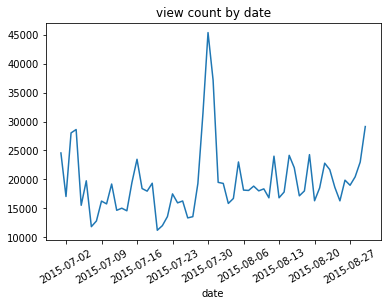

In [94]:
views_by_date['product'].plot(title='view count by date',rot=30)

## 统计24小时的浏览高峰

In [53]:
views_by_hour = views.groupby(views['date'].dt.hour).count()

In [54]:
views_by_hour.head()

,date,action,user_Id,product
date,,,,
0,69806,69806,69806,69806
1,42582,42582,42582,42582
2,24408,24408,24408,24408
3,15930,15930,15930,15930
4,10563,10563,10563,10563


* MySQL实现

```
select hour(date),count(action)
from views
group by hour(date)
limit 5
```


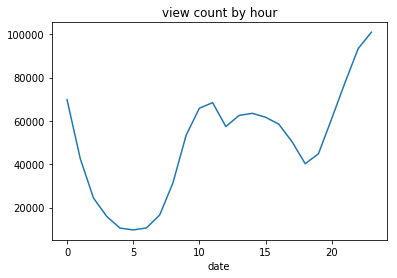

In [64]:
views_by_hour['product'].plot(title='view count by hour')

* 20~24点之后的网站浏览高峰

# 可视化

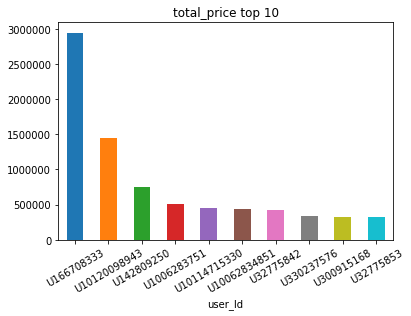

In [95]:
orders.groupby('user_Id')['total_price'].sum().sort_values(ascending=False)[:10].plot.bar(title='total_price top 10',rot=30)

In [82]:
views_daily_count = views.groupby(views['date'].dt.date)['action'].count()
orders_daily_count = orders.groupby(orders['date'].dt.date)['action'].count()

In [83]:
df = pd.concat([views_daily_count,orders_daily_count],axis=1)

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [84]:
df.dropna(inplace=True)

In [91]:
df.columns = ['views','orders']

In [92]:
df.head()

,views,orders
2015-07-01,24569,2324.0
2015-07-02,17043,2059.0
2015-07-03,28041,1778.0
2015-07-04,28625,2166.0
2015-07-05,15522,1413.0


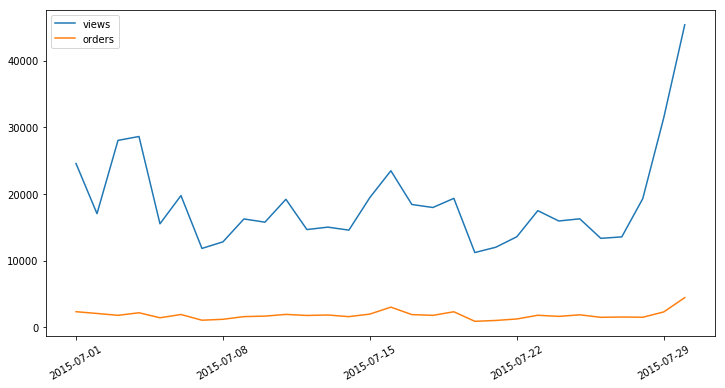

In [96]:
df.plot(figsize=(12,6),rot=30)

浏览量与购买量
>儒冠多误身